In [ ]:
#Étant un groupe en Computer Vision, nous avons entrepris de reconstituer un réseau de neurones convolutionnel (CNN). 
#Pour cela, nous avons recodé manuellement les fonctions de convolution, de pooling ainsi que les couches entièrement connectées, en nous appuyant sur PyTorch.
#L’évaluation du modèle a été réalisée à l’aide du jeu de données MNIST.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
class LRScheduler:
    def __init__(self, optimizer, initial_lr):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.lr = initial_lr
        self.iteration = 0  # Ou self.epoch = 0 si basé sur les époques
    
    def update_lr(self, metrics=None):
        self.iteration += 1
        self.lr = self.initial_lr / (1 + 0.01 * self.iteration) 

    def step(self, metrics=None):
        self.update_lr(metrics)
        self.optimizer.learning_rate = self.lr

class LRSchedulerOnPlateau(LRScheduler):
    def __init__(self, optimizer, initial_lr, patience=10, factor=0.1, min_lr=1e-6, mode='min', threshold=1e-4):
        super().__init__(optimizer, initial_lr)
        self.patience = patience  # Nombre d'époques sans amélioration avant de réduire le taux
        self.factor = factor  # Facteur de réduction du taux d'apprentissage
        self.min_lr = min_lr  # Valeur minimale du taux d'apprentissage
        self.mode = mode  # 'min' : réduire le taux quand la métrique cesse de diminuer, 'max' : inverse
        self.threshold = threshold  # Seuil pour déterminer la réduction de la métrique
        self.best_metric = float('inf') if mode == 'min' else float('-inf')  # Meilleure métrique observée
        self.num_bad_epochs = 0  # Nombre d'époques sans amélioration de la métrique

    def update_lr(self, metric):
        if self.mode == 'min':
            if metric < self.best_metric - self.threshold:
                self.best_metric = metric
                self.num_bad_epochs = 0
            else:
                self.num_bad_epochs += 1
        else:
            if metric > self.best_metric + self.threshold:
                self.best_metric = metric
                self.num_bad_epochs = 0
            else:
                self.num_bad_epochs += 1
        
        if self.num_bad_epochs >= self.patience:
            print("Reducing learning rate.")
            self.lr = max(self.lr * self.factor, self.min_lr)
            self.num_bad_epochs = 0
            self.optimizer.learning_rate = self.lr

In [3]:
class TorchOptimizerAdapter:
    """Adapter to expose a learning_rate attribute for utils schedulers."""

    def __init__(self, torch_optimizer):
        self.torch_optimizer = torch_optimizer

    @property
    def learning_rate(self):
        return self.torch_optimizer.learning_rate

    @learning_rate.setter
    def learning_rate(self, lr):
        self.torch_optimizer.learning_rate = lr


class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if isinstance(stride, int):
            stride = (stride, stride)
        if isinstance(padding, int):
            padding = (padding, padding)
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        weight_shape = (out_channels, in_channels, kernel_size[0], kernel_size[1])
        self.weight = nn.Parameter(torch.randn(*weight_shape) * 0.02)
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None

    def forward(self, x):
        kh, kw = self.kernel_size
        sh, sw = self.stride
        ph, pw = self.padding

        if ph != 0 or pw != 0:
            n, c, h, w = x.shape
            padded = torch.zeros(
                (n, c, h + 2 * ph, w + 2 * pw),
                device=x.device,
                dtype=x.dtype,
            )
            padded[:, :, ph : ph + h, pw : pw + w] = x
            x = padded

        n, c, h, w = x.shape
        out_h = (h - kh) // sh + 1
        out_w = (w - kw) // sw + 1

        patches = (
            x.unfold(2, kh, sh)
            .unfold(3, kw, sw)
            .contiguous()
        )
        patches = patches.view(n, c, out_h, out_w, kh * kw)
        patches = patches.permute(0, 2, 3, 1, 4).contiguous()
        patches = patches.view(n * out_h * out_w, c * kh * kw)

        weight = self.weight.view(self.weight.size(0), -1)
        out = patches @ weight.t()
        if self.bias is not None:
            out = out + self.bias

        out = out.view(n, out_h, out_w, -1).permute(0, 3, 1, 2).contiguous()
        return out


class ReLU(nn.Module):
    def forward(self, x):
        return torch.maximum(x, torch.zeros(1, device=x.device, dtype=x.dtype))


class MaxPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, x):
        if isinstance(self.kernel_size, int):
            kh, kw = self.kernel_size, self.kernel_size
        else:
            kh, kw = self.kernel_size

        if isinstance(self.stride, int):
            sh, sw = self.stride, self.stride
        else:
            sh, sw = self.stride

        ph = pw = self.padding
        if isinstance(self.padding, tuple):
            ph, pw = self.padding

        if ph != 0 or pw != 0:
            n, c, h, w = x.shape
            padded = torch.full(
                (n, c, h + 2 * ph, w + 2 * pw),
                float("-inf"),
                device=x.device,
                dtype=x.dtype,
            )
            padded[:, :, ph : ph + h, pw : pw + w] = x
            x = padded

        n, c, h, w = x.shape
        out_h = (h - kh) // sh + 1
        out_w = (w - kw) // sw + 1

        patches = x.unfold(2, kh, sh).unfold(3, kw, sw).contiguous()
        patches = patches.view(n, c, out_h, out_w, kh * kw)
        out, _ = patches.max(dim=-1)
        return out


class Flatten(nn.Module):
    def __init__(self, start_dim=1):
        super().__init__()
        self.start_dim = start_dim

    def forward(self, x):
        shape = x.shape[: self.start_dim] + (-1,)
        return x.reshape(*shape)


class Linear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.02)
        self.bias = nn.Parameter(torch.zeros(out_features)) if bias else None

    def forward(self, x):
        out = x @ self.weight.t()
        if self.bias is not None:
            out = out + self.bias
        return out


class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training or self.p == 0.0:
            return x
        keep_prob = 1.0 - self.p
        mask = torch.bernoulli(torch.full_like(x, keep_prob))
        return x * mask / keep_prob


class CrossEntropyLoss(nn.Module):
    def forward(self, logits, targets):
        # logits: (N, C), targets: (N,)
        shifted = logits - logits.max(dim=1, keepdim=True).values
        exp = torch.exp(shifted)
        log_probs = shifted - torch.log(exp.sum(dim=1, keepdim=True))
        nll = -log_probs.gather(1, targets.view(-1, 1)).squeeze(1)
        return nll.mean()


#Nous avons adapte l'Adam du cours pour qu'il fonctionne avec les dimensions des images.
class Adam:
    def __init__(self, params, learning_rate=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = list(params)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue
            g = p.grad
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g * g)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            p.data -= self.learning_rate * m_hat / (torch.sqrt(v_hat) + self.eps)



In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            Conv2d(1, 32, kernel_size=3, padding=1),
            ReLU(),
            MaxPool2d(2),
            Conv2d(32, 64, kernel_size=3, padding=1),
            ReLU(),
            MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            Flatten(),
            Linear(64 * 7 * 7, 128),
            ReLU(),
            Dropout(0.25),
            Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [5]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)

    return total_loss / total, correct / total


def evaluate_metrics(model, loader, criterion, device, num_classes=10):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    per_class_correct = torch.zeros(num_classes, device=device)
    per_class_total = torch.zeros(num_classes, device=device)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)

            for cls in range(num_classes):
                cls_mask = y == cls
                per_class_total[cls] += cls_mask.sum()
                per_class_correct[cls] += (preds[cls_mask] == cls).sum()

    per_class_acc = (per_class_correct / per_class_total.clamp(min=1)).tolist()
    return total_loss / total, correct / total, per_class_acc


def plot_training_results(history):
    """Génère un graphique complet des métriques d'entraînement."""
    epochs = history['epoch']
    
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # --- Axe 1 : Pertes (Loss) ---
    color_loss = 'tab:red'
    ax1.set_xlabel('Époques')
    ax1.set_ylabel('Loss', color=color_loss)
    lns1 = ax1.plot(epochs, history['train_loss'], '--', color='orange', label='Train Loss')
    lns2 = ax1.plot(epochs, history['val_loss'], '-', color=color_loss, marker='o', label='Val Loss')
    ax1.tick_params(axis='y', labelcolor=color_loss)
    ax1.grid(True, alpha=0.3)

    # --- Axe 2 : Précision (Accuracy) ---
    ax2 = ax1.twinx()
    color_acc = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color_acc)
    lns3 = ax2.plot(epochs, history['val_acc'], '-', color=color_acc, marker='s', label='Val Acc')
    ax2.tick_params(axis='y', labelcolor=color_acc)
    ax2.set_ylim(0, 1.05) # L'accuracy est toujours entre 0 et 1

    # --- Axe 3 : Learning Rate (LR) ---
    # On décale l'axe vers la droite pour la visibilité
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    color_lr = 'tab:green'
    ax3.set_ylabel('Learning Rate', color=color_lr)
    lns4 = ax3.plot(epochs, history['lr'], ':', color=color_lr, marker='^', label='LR')
    ax3.tick_params(axis='y', labelcolor=color_lr)
    ax3.set_yscale('log') # Très important car le LR diminue par facteurs (0.1, 0.01...)

    # Regrouper toutes les légendes en une seule
    lns = lns1 + lns2 + lns3 + lns4
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='lower left', frameon=True, shadow=True)

    plt.title('Analyse de l\'entraînement (Modèle Perso)', fontsize=14)
    fig.tight_layout()
    plt.show()


In [6]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    )

    history = {
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    full_dataset = datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )
    test_size = int(0.1 * len(full_dataset))
    train_size = len(full_dataset) - test_size
    train_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42),
    )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    model = SimpleCNN().to(device)
    criterion = CrossEntropyLoss()

    torch_optim = Adam(model.parameters(), learning_rate=1e-3)
    optim_adapter = TorchOptimizerAdapter(torch_optim)
    scheduler = LRSchedulerOnPlateau(
        optimizer=optim_adapter,
        initial_lr=1e-3,
        patience=2,
        factor=0.5,
        min_lr=1e-5,
        mode="min",
        threshold=1e-4,
    )

    epochs = 5
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, torch_optim, criterion, device
        )
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)

        scheduler.step(val_loss)

        current_lr = optim_adapter.learning_rate
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        print(f"Epoch {epoch}: Loss={val_loss:.4f}, Acc={val_acc:.4f}, LR={current_lr:.6e}")

    test_loss, test_acc, per_class_acc = evaluate_metrics(
        model, test_loader, criterion, device, num_classes=10
    )

    plot_training_results(history)

    print(f"\nFinal test_loss={test_loss:.4f} test_acc={test_acc:.4f}")
    print("Per-class accuracy:")
    for idx, acc in enumerate(per_class_acc):
        print(f"  class {idx}: {acc:.4f}")


Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Epoch 1: Loss=0.0758, Acc=0.9778, LR=1.000000e-03
Epoch 2: Loss=0.0561, Acc=0.9838, LR=1.000000e-03
Epoch 3: Loss=0.0511, Acc=0.9858, LR=1.000000e-03
Epoch 4: Loss=0.0472, Acc=0.9880, LR=1.000000e-03
Epoch 5: Loss=0.0442, Acc=0.9882, LR=1.000000e-03


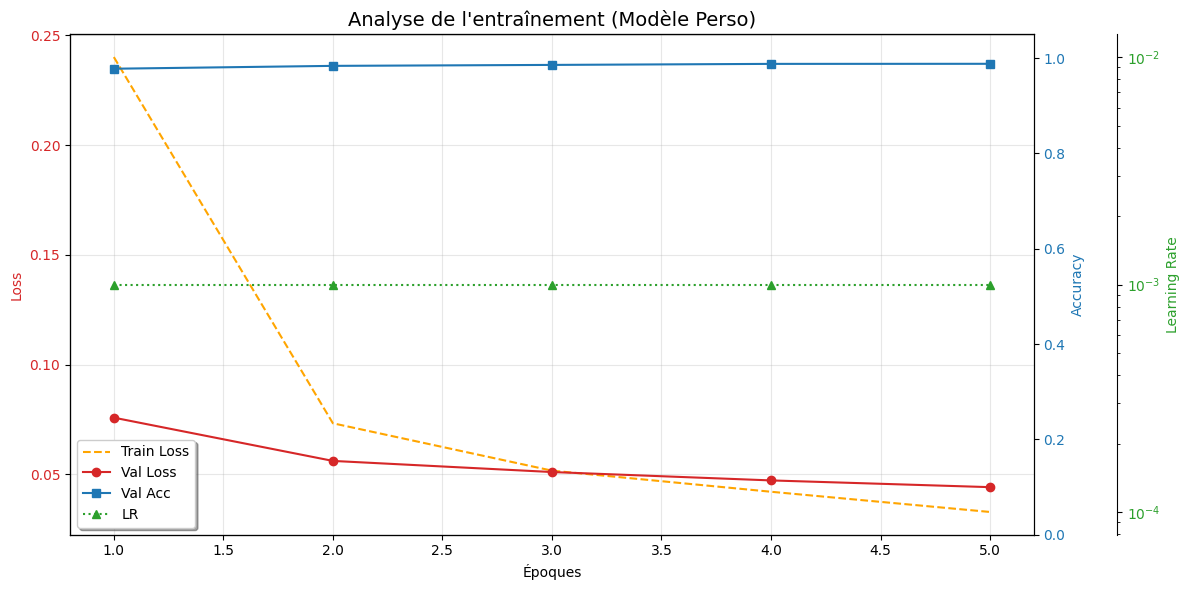


Final test_loss=0.0442 test_acc=0.9882
Per-class accuracy:
  class 0: 0.9966
  class 1: 0.9910
  class 2: 0.9843
  class 3: 0.9936
  class 4: 0.9866
  class 5: 0.9923
  class 6: 0.9869
  class 7: 0.9924
  class 8: 0.9799
  class 9: 0.9775


In [7]:
main()